<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/dacon_timeseries/blob/main/neural_prophet_baseline_tuning_0513.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Parameter Tuning
https://neuralprophet.com/hyperparameter-selection/#regularization-related-parameters

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
from glob import glob
from PIL import Image
import os
os.chdir('/content/gdrive/My Drive/dacon_timeseries')

In [ ]:
#!pip install neuralprophet

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 748.8MB 22kB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [ ]:
dangjin_fcst_data = pd.read_csv('dangjin_fcst_data.csv')
dangjin_obs_data = pd.read_csv('dangjin_obs_data.csv')
energy = pd.read_csv('energy.csv') # 발전소별 발전량
sample_submission = pd.read_csv('sample_submission.csv')
site_info = pd.read_csv('site_info.csv') # 발전소 정보
ulsan_fcst_data = pd.read_csv('ulsan_fcst_data.csv')
ulsan_obs_data = pd.read_csv('ulsan_obs_data.csv')

# EDA

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from glob import glob
import plotly.express as px
from neuralprophet import NeuralProphet

## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## __site_info.csv - 발전소 정보__  
- Id : 사이트 식별자
- Capacity : 발전소 발전용량(MW)
- Address : 주소
- InstallationAngle : 설치각(º)
- IncidentAngle : 입사각(º)
- Latitude : 위도
- Longitude : 경도

In [ ]:
site_info

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
1,당진자재창고태양광,0.7,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
2,당진태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20.0,20.0,35.477651,129.380778


## __energy.csv - 발전소별 발전량__
- time : 1시간 단위 계량된 시간  
  (ex-2018-03-01 1:00:00 => 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
- dangjin_floating : 당진수상태양광 발전량(KW)
- dangjin_warehouse : 당진자재창고태양광 발전량(KW)
- dangjin : 당진태양광 발전량(KW)
- ulsan : 울산태양광 발전량(KW)

In [ ]:
energy.shape

(25632, 5)

In [ ]:
energy # 2018-3-1 ~ 2021-1-31 1시간 단위로 기록된 각 발전소별 발전량 데이터

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0
25628,2021-01-31 21:00:00,0.0,0.0,0,0
25629,2021-01-31 22:00:00,0.0,0.0,0,0
25630,2021-01-31 23:00:00,0.0,0.0,0,0


In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               25632 non-null  object 
 1   dangjin_floating   25608 non-null  float64
 2   dangjin_warehouse  25584 non-null  float64
 3   dangjin            25632 non-null  int64  
 4   ulsan              25632 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1001.4+ KB


In [ ]:
energy.describe()

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
count,25608.000000,25584.000000,25632.000000,25632.000000
mean,122.056311,92.476665,139.653285,64.159761
std,192.041585,146.423366,220.491387,101.020447
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,191.000000,145.000000,227.000000,101.000000
max,753.000000,593.000000,867.000000,392.000000


- 평균적으로 '당진'이 가장 많이 발전
- count값이 다른 것으로 보아 결측치가 존재함을 알 수 있다.

In [ ]:
energy.isnull().sum()

time                  0
dangjin_floating     24
dangjin_warehouse    48
dangjin               0
ulsan                 0
dtype: int64

- '당진수상', '당진자재창고'에 결측치 존재

In [ ]:
type(energy['time'])

pandas.core.series.Series

In [ ]:
energy['date'] = energy['time'].apply(lambda x: x.split()[0])
energy['time'] = energy['time'].apply(lambda x: x.split()[1])
energy['time'] = energy['time'].str.rjust(8,'0') # 한자릿수 시간 앞에 0 추가 ex) 3시 -> 03시
energy['time']

0        01:00:00
1        02:00:00
2        03:00:00
3        04:00:00
4        05:00:00
           ...   
25627    20:00:00
25628    21:00:00
25629    22:00:00
25630    23:00:00
25631    24:00:00
Name: time, Length: 25632, dtype: object

In [ ]:
from datetime import timedelta

# 24시를 00시로 바꿔주기
energy.loc[energy['time']=='24:00:00','time'] = '00:00:00'
energy['time'] = energy['date'] + ' ' + energy['time']
energy['time'] = pd.to_datetime(energy['time'])
energy.loc[energy['time'].dt.hour==0,'time'] += timedelta(days=1)
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,date
0,2018-03-01 01:00:00,0.0,0.0,0,0,2018-03-01
1,2018-03-01 02:00:00,0.0,0.0,0,0,2018-03-01
2,2018-03-01 03:00:00,0.0,0.0,0,0,2018-03-01
3,2018-03-01 04:00:00,0.0,0.0,0,0,2018-03-01
4,2018-03-01 05:00:00,0.0,0.0,0,0,2018-03-01
...,...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0,2021-01-31
25628,2021-01-31 21:00:00,0.0,0.0,0,0,2021-01-31
25629,2021-01-31 22:00:00,0.0,0.0,0,0,2021-01-31
25630,2021-01-31 23:00:00,0.0,0.0,0,0,2021-01-31


In [ ]:
#energy.loc[energy['time']=='24:00:00','time'] = '00:00:00'
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               25632 non-null  datetime64[ns]
 1   dangjin_floating   25608 non-null  float64       
 2   dangjin_warehouse  25584 non-null  float64       
 3   dangjin            25632 non-null  int64         
 4   ulsan              25632 non-null  int64         
 5   date               25632 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 1.2+ MB


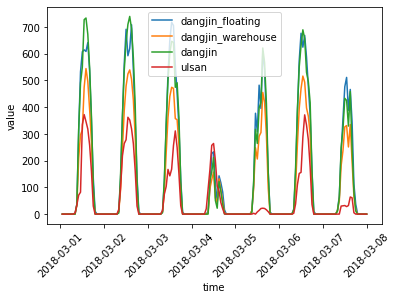

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.lineplot(x='time', y='dangjin_floating', data=energy[:24*7])
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.lineplot(x='time', y='dangjin_warehouse', data=energy[:24*7])
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.lineplot(x='time', y='dangjin', data=energy[:24*7])
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.lineplot(x='time', y='ulsan', data=energy[:24*7])
plt.setp(g.get_xticklabels(), rotation=45)
g.set(ylabel='value')
plt.legend(labels=['dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan'])

plt.show()

- 데이터의 row는 25632개가 있어 약 일주일 정도의 에너지 발전량을 시각화해보자.
- 용량이 큰 당진이 대체로 많이 발전하고, 
- 용량이 적은 울산이 대체로 적게 발전
- 3월 4일 경에는 모든 발전소의 발전량이 낮은데 아무래도 날씨의 영향인 것 같다.

In [ ]:
# time column을 분해하여 의미있을 것 같은 month와 hour로 시각화해보자.
energy['month'] = energy['time'].dt.month
energy['hour'] = energy['time'].dt.hour

### 월별 발전량

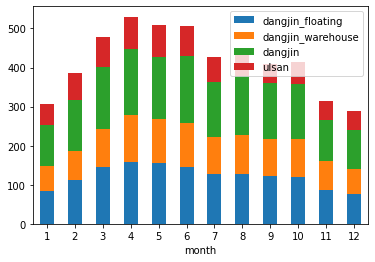

In [ ]:
mean_month = energy.groupby('month').mean()
g = mean_month.iloc[:,:-1].plot(kind='bar', stacked=True)
plt.setp(g.get_xticklabels(), rotation=0)
plt.show()

- 일반적으로 해가 가장 높게뜨고 기온이 높은 여름(6월~8월)에 발전량이 가장 많을 것 같지만
- 평균적으론 봄(3월~5월)이 발전량이 더 높다.
- 이는 태양광판넬의 입사각이 20~30도라는 점, 여름에 강수량이 많다는 점에서 충분히 이해가 갈 것 같다.

### 시간별 발전량

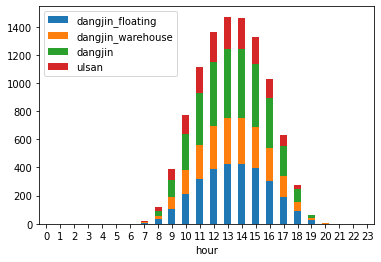

In [ ]:
mean_hour = energy.groupby('hour').mean()
g = mean_hour.iloc[:,:-1].plot(kind='bar', stacked=True)
plt.setp(g.get_xticklabels(), rotation=0)
plt.show()

- 지난 3년간 저녁 8시부터 다음날 아침 06시까지는 발전량이 없었다.
- 해당 시간은 0으로 초기화해도 될 것 같다.
- 오후 1시, 2시가 평균 발전량이 가장 높았다.

### 발전소별 발전량 분포

In [ ]:
cols = ['dangjin_floating','dangjin_warehouse','dangjin','ulsan']
energy[cols][energy[cols]!=0].head(30)

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0
8,36.0,33.0,37.0,35.0
9,313.0,209.0,318.0,71.0


In [ ]:
hhh = energy.iloc[:,1:5]
hhh = hhh[(hhh.T != 0).any()]
hhh

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
7,0.0,0.0,0,4
8,36.0,33.0,37,35
9,313.0,209.0,318,71
10,532.0,296.0,490,82
11,607.0,315.0,550,334
...,...,...,...,...
25621,397.0,261.0,468,294
25622,297.0,256.0,352,259
25623,230.0,166.0,261,196
25624,76.0,65.0,81,83


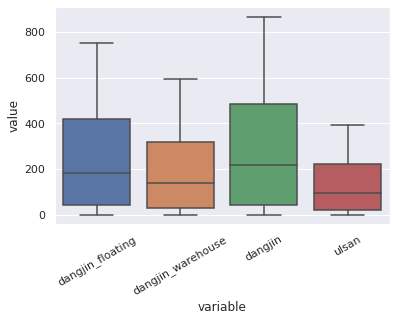

In [ ]:
sns.set(style="darkgrid")
g = sns.boxplot(y="value", x="variable", data=pd.melt(hhh))
plt.setp(g.get_xticklabels(), rotation=30)
plt.show()

## __당진 기상관측자료__

In [ ]:
dangjin_obs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25626 entries, 0 to 25625
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25626 non-null  int64  
 1   지점명        25626 non-null  object 
 2   일시         25626 non-null  object 
 3   기온(°C)     25589 non-null  float64
 4   풍속(m/s)    25590 non-null  float64
 5   풍향(16방위)   25590 non-null  float64
 6   습도(%)      25591 non-null  float64
 7   전운량(10분위)  21656 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
dangjin_obs_data.isnull().sum()

지점              0
지점명             0
일시              0
기온(°C)         37
풍속(m/s)        36
풍향(16방위)       36
습도(%)          35
전운량(10분위)    3970
dtype: int64

- 일부 null값이 보이고 특히 전운량의 결측치가 많다. 
- 구름없이 맑은 날은 결측치로 처리됨을 예상할 수 있다.
  - 전운량: 맑은 날이라고 가정, 0으로 fill
  - 기온, 풍속, 풍향, 습도: 바로 앞 시간대의 관측량으로 대체, ffill

In [ ]:
def weather_preprocessing(df):
    df['전운량(10분위)'].fillna(0, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df['일시'] =  pd.to_datetime(df['일시'])
    return df

In [ ]:
dangjin_obs_data = weather_preprocessing(dangjin_obs_data)
dangjin_obs_data.isnull().sum()

지점           0
지점명          0
일시           0
기온(°C)       0
풍속(m/s)      0
풍향(16방위)     0
습도(%)        0
전운량(10분위)    0
dtype: int64

### 발전량과 날씨의 상관관계 (당진)

In [ ]:
df_joined = pd.merge(energy, dangjin_obs_data, left_on='time', right_on='일시', how='inner')
cols = ['time','dangjin_floating', 'dangjin_warehouse', 'dangjin', '기온(°C)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '전운량(10분위)']
dangjin = df_joined[cols]

In [ ]:
dangjin.corr() # 날씨와의 상관계수

,dangjin_floating,dangjin_warehouse,dangjin,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
dangjin_floating,1.000000,0.961408,0.974142,0.307088,0.438443,0.344152,-0.632884,-0.188188
dangjin_warehouse,0.961408,1.000000,0.972938,0.311508,0.426527,0.339161,-0.637108,-0.168499
dangjin,0.974142,0.972938,1.000000,0.294323,0.435736,0.348794,-0.644704,-0.185427
기온(°C),0.307088,0.311508,0.294323,1.000000,0.168179,0.128834,-0.000126,0.037965
풍속(m/s),0.438443,0.426527,0.435736,0.168179,1.000000,0.534637,-0.416005,0.006391
풍향(16방위),0.344152,0.339161,0.348794,0.128834,0.534637,1.000000,-0.371380,-0.004386
습도(%),-0.632884,-0.637108,-0.644704,-0.000126,-0.416005,-0.371380,1.000000,0.176116
전운량(10분위),-0.188188,-0.168499,-0.185427,0.037965,0.006391,-0.004386,0.176116,1.000000


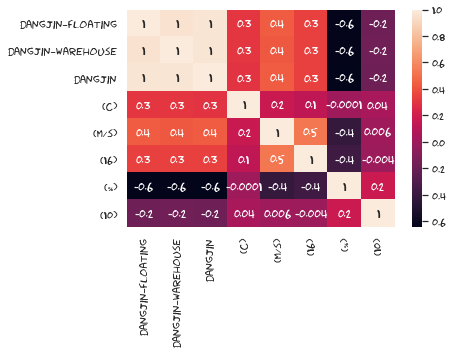

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] = 'Humor Sans'

sns.heatmap(dangjin.corr(), annot=True, fmt='.1g')
plt.show()

- 기온은 0.3, 풍속은 0.43, 풍향은 0.4 정도의 양의 상관관계를 보이고 있으며, 
- 습도 -0.63, 전운량 -0.18 정도의 음의 상관관계를 보이고 있다.
- 절댓값으로만 보자면 습도가 가장 상관관계가 뚜렷하다.

## __울산 기상관측자료__

In [ ]:
ulsan_obs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25632 non-null  int64  
 1   지점명        25632 non-null  object 
 2   일시         25632 non-null  object 
 3   기온(°C)     25628 non-null  float64
 4   풍속(m/s)    25631 non-null  float64
 5   풍향(16방위)   25631 non-null  float64
 6   습도(%)      25631 non-null  float64
 7   전운량(10분위)  24807 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
ulsan_obs_data.isnull().sum()

지점             0
지점명            0
일시             0
기온(°C)         4
풍속(m/s)        1
풍향(16방위)       1
습도(%)          1
전운량(10분위)    825
dtype: int64

In [ ]:
ulsan_obs_data = weather_preprocessing(ulsan_obs_data)
ulsan_obs_data.isnull().sum()

지점           0
지점명          0
일시           0
기온(°C)       0
풍속(m/s)      0
풍향(16방위)     0
습도(%)        0
전운량(10분위)    0
dtype: int64

- 울산은 당진보다 상대적으로 적은 결측치를 가지고 있다. 
- 같은 방법으로 전처리



### 발전량과 날씨의 상관관계 (울산)

In [ ]:
df_joined = pd.merge(energy, ulsan_obs_data, left_on='time', right_on='일시', how='inner')
cols = ['time','ulsan', '기온(°C)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '전운량(10분위)']
ulsan = df_joined[cols]

In [ ]:
ulsan.corr() # 날씨와의 상관계수

,ulsan,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
ulsan,1.000000,0.240879,0.307515,-0.186768,-0.447506,-0.190440
기온(°C),0.240879,1.000000,-0.070631,-0.293445,0.355624,0.203843
풍속(m/s),0.307515,-0.070631,1.000000,0.172195,-0.300215,-0.014533
풍향(16방위),-0.186768,-0.293445,0.172195,1.000000,-0.097894,-0.057273
습도(%),-0.447506,0.355624,-0.300215,-0.097894,1.000000,0.448958
전운량(10분위),-0.190440,0.203843,-0.014533,-0.057273,0.448958,1.000000


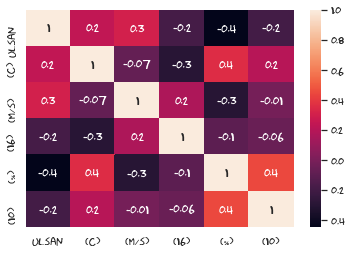

In [ ]:
sns.heatmap(ulsan.corr(), annot=True, fmt='.1g')
plt.show()

- 울산은 당진과 다르게 풍향에서 음의 상관관계를 보이고 있다. 
- 상관계수의 절댓값이 그리 크지않은 값들이라 유의미하다고는 보기 힘들겠다.

# NeuralProphet
* Energy 값만 사용하는 방식

In [ ]:
def sola_nmae(answer, pred, cap):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= cap
    
    target_idx = np.where(answer>=cap*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [ ]:
# validation, 시각화를 위한 함수
def make_val(colo, cap): 
  column = colo
  df = pd.DataFrame()
  df['ds'] = energy['time']
  df['y'] = energy[column]
  df.y = df.y.fillna(0)
  train = df[:-24*30] #21년 1월 1일까지   #24*30이 24시간 *30일 이네
  val = df[-24*30:] #21년 1월 2일 ~ 1월 31일

# Neural Prophet 설명 - http://insightcampus.co.kr:9090/insightcommunity/?mod=document&uid=12964
# parameter tuning - https://neuralprophet.com/hyperparameter-selection/#regularization-related-parameters

  model = NeuralProphet(n_forecasts=330, n_lags = 390, daily_seasonality=True, yearly_seasonality=True )
  loss = model.fit(train, freq="H")  #freq H랑 D 차이가..? => D로 하면 에러남..
  df_pred = model.make_future_dataframe(train, periods=24*30)  #train 데이터 이후로 periods만큼 예측
  predict = model.predict(df_pred)
  return predict
  '''
  #visualization
  plt.figure(figsize=(20,5))
  plt.plot(predict['yhat1'].values, label='pred')
  plt.plot(val.y.values, label='Actual') 
  plt.legend()
  print('CV Score : ', sola_nmae(val.y.values, predict['yhat1'].values, cap))
  plt.show()
'''

In [ ]:
pred1=make_val('dangjin_floating', 1000)
pred2=make_val('dangjin_warehouse', 700)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it, SmoothL1Loss=0.0147, MAE=63.5, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:29<00:00,  5.98s/it, SmoothL1Loss=0.0148, MAE=49.8, RegLoss=0]


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,yhat5,residual5,yhat6,residual6,yhat7,residual7,yhat8,residual8,yhat9,residual9,yhat10,residual10,yhat11,residual11,yhat12,residual12,yhat13,residual13,yhat14,residual14,yhat15,residual15,yhat16,residual16,yhat17,residual17,yhat18,residual18,yhat19,residual19,...,ar295,ar296,ar297,ar298,ar299,ar300,ar301,ar302,ar303,ar304,ar305,ar306,ar307,ar308,ar309,ar310,ar311,ar312,ar313,ar314,ar315,ar316,ar317,ar318,ar319,ar320,ar321,ar322,ar323,ar324,ar325,ar326,ar327,ar328,ar329,ar330,trend,season_yearly,season_weekly,season_daily
0,2020-12-16 19:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2020-12-16 20:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2020-12-16 21:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2020-12-16 22:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2020-12-16 23:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2021-01-15 14:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,122.74,None,None,None,None,78.7719,-29.0222,1.78194,124.003
716,2021-01-15 15:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,76.8224,None,None,None,78.7717,-29.011,1.94207,111.664
717,2021-01-15 16:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,Non

In [ ]:
pred

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,yhat5,residual5,yhat6,residual6,yhat7,residual7,yhat8,residual8,yhat9,residual9,yhat10,residual10,yhat11,residual11,yhat12,residual12,yhat13,residual13,yhat14,residual14,yhat15,residual15,yhat16,residual16,yhat17,residual17,yhat18,residual18,yhat19,residual19,...,ar295,ar296,ar297,ar298,ar299,ar300,ar301,ar302,ar303,ar304,ar305,ar306,ar307,ar308,ar309,ar310,ar311,ar312,ar313,ar314,ar315,ar316,ar317,ar318,ar319,ar320,ar321,ar322,ar323,ar324,ar325,ar326,ar327,ar328,ar329,ar330,trend,season_yearly,season_weekly,season_daily
0,2020-12-16 19:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2020-12-16 20:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2020-12-16 21:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2020-12-16 22:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2020-12-16 23:00:00,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2021-01-15 14:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,199.419,None,None,None,None,94.4125,-27.8116,-0.36821,111.026
716,2021-01-15 15:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,149.731,None,None,None,94.4137,-27.7821,-0.138421,101.673
717,2021-01-15 16:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,Na

갑자기 훅 낮아지는 때의 원인을 모르니 그걸 잘 못잡는듯

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
Epoch[20/20]: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, SmoothL1Loss=0.0148, MAE=75.3, RegLoss=0]


CV Score :  13.664984893798826


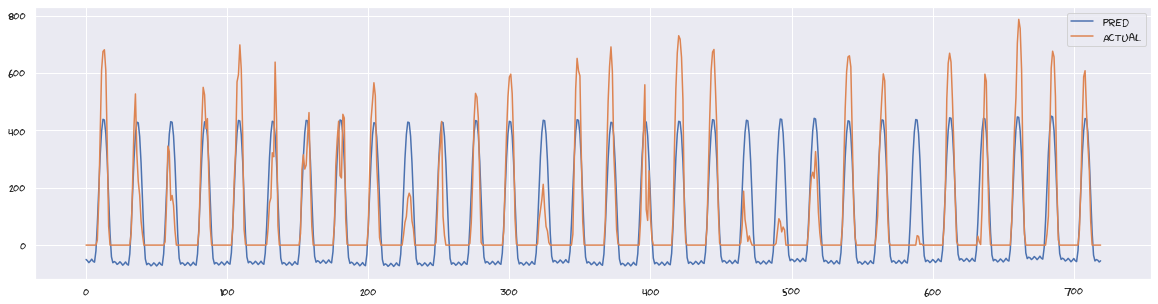

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
Epoch[20/20]: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s, SmoothL1Loss=0.0156, MAE=35.9, RegLoss=0]


CV Score :  9.930387695312499


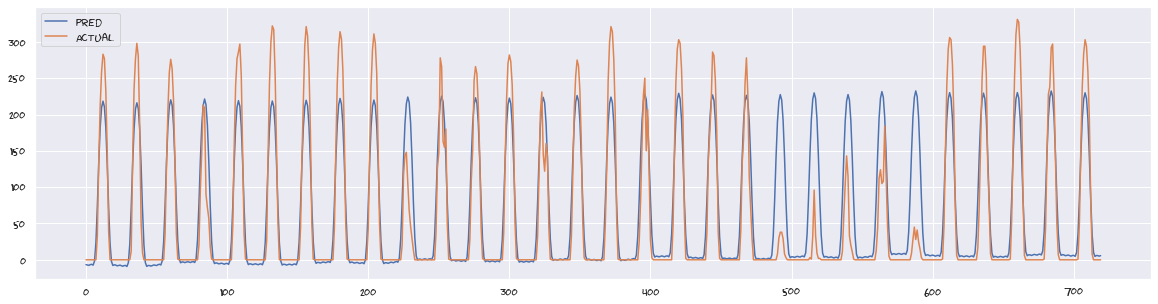

In [ ]:
make_val('dangjin', 1000)
make_val('ulsan', 500)

* 전반적으로 예측을 다 똑같이 하고있음을 알 수 있다..
* 0 값을 조절(relu 적용)했더니 에러가 더 높아진 경우도 있음... 흠... 근데 오차범위인듯 ㅇㅇ

In [ ]:
def train(colo, cap):
  column = colo
  df = pd.DataFrame()
  df['ds'] = energy['time']
  df['y'] = energy[column]
  df.y = df.y.fillna(0)

  model = NeuralProphet(yearly_seasonality=True, daily_seasonality=True)
  loss = model.fit(df, freq="H")

  #predict
  df_pred = model.make_future_dataframe(df, periods=9000)
  predict = model.predict(df_pred)

  return predict

In [ ]:
flt_pred = train('dangjin_floating', 1000)
ware_pred = train('dangjin_warehouse', 700)
d_pred = train('dangjin', 1000)
u_pred = train('ulsan', 500)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s, SmoothL1Loss=0.016, MAE=69.7, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s, SmoothL1Loss=0.0161, MAE=53.9, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s, SmoothL1Loss=0.0159, MAE=81.1, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s, SmoothL1Loss=0.016, MAE=36.4, RegLoss=0]


In [ ]:
flt_pred

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2021-02-01 01:00:00,None,-27.785107,None,124.634125,-21.597786,-7.068682,-123.752777
1,2021-02-01 02:00:00,None,-27.307579,None,124.635773,-21.553122,-6.736641,-123.653580
2,2021-02-01 03:00:00,None,-25.353954,None,124.637405,-21.508421,-6.378116,-122.104820
3,2021-02-01 04:00:00,None,-23.536476,None,124.639038,-21.463676,-5.998221,-120.713615
4,2021-02-01 05:00:00,None,-23.904758,None,124.640671,-21.418896,-5.602184,-121.524338
...,...,...,...,...,...,...,...,...
8995,2022-02-10 20:00:00,None,2.542553,None,139.354919,-10.605187,-0.743757,-125.463417
8996,2022-02-10 21:00:00,None,1.423721,None,139.356537,-10.555081,-1.006593,-126.371147
8997,2022-02-10 22:00:00,None,5.354996,None,139.358170,-10.504971,-1.232359,-122.265862
8998,2022-02-10 23:00:00,None,6.738724,None,139.359818,-10.454850,-1.417517,-120.748726


In [ ]:
def sub(predict, col, file):
  # 2021-02-01 ~ 2021-03-01
  predict_1 = predict.copy()
  predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
  predict_1 = predict_1.query('ds <= "2021-03-01 00:00:00"') #submission 파일에는28일 24시로 되어있음
  #print(predict_1)
  # 2021-06-09 ~ 2021-07-09
  predict_2 = predict.copy()
  predict_2 = predict_2.query('ds > "2021-06-09 00:00:00"')
  predict_2 = predict_2.query('ds <= "2021-07-09 00:00:00"')
  #print(predict_2)
  file[col] = list(predict_1['yhat1']) + list(predict_2['yhat1'])
  
  return file


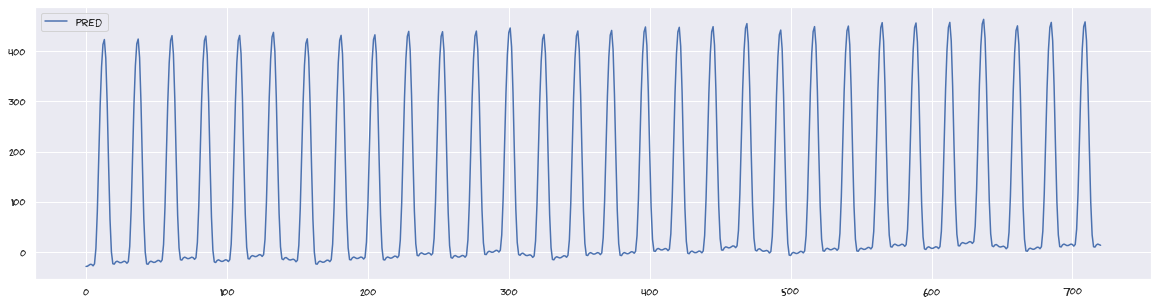

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(flt_pred.loc[:720,'yhat1'].values, label='pred')
plt.legend()
plt.show()

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
sub_file = sub(flt_pred, 'dangjin_floating', submission)
sub_file = sub(ware_pred, 'dangjin_warehouse', sub_file)
sub_file = sub(d_pred, 'dangjin', sub_file)
sub_file = sub(u_pred, 'ulsan', sub_file)

In [ ]:
sub_file.to_csv('neural_prophet_submission0512.csv', index =False)

* Prediction 그대로 냈을때 점수 13.66631 (109등 ;;)


### 작은값 0으로 조절

In [ ]:
def relu(x):
  if x < 15:
    return 0
  else:
    return x

In [ ]:
sub_file_relu=sub_file[['dangjin_floating','dangjin_warehouse','dangjin','ulsan']].applymap(relu)

In [ ]:
sub_file_relu['time']=sub_file['time']
sub_file_relu=sub_file_relu[['time','dangjin_floating','dangjin_warehouse','dangjin','ulsan']]

In [ ]:
sub_file_relu

In [ ]:
sub_file_relu.to_csv('neural_prophet_submission_relu_0512.csv', index =False)

* 놀랍게도 0으로 조정한것과 아닌것은 성능이 똑같았다.. (왜지..?)